<a href="https://colab.research.google.com/github/AstraBert/DebateLLM-Championship/blob/main/DebateChampionshipLLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install necessary dependencies

In [ ]:
! pip install huggingface_hub datasets --upgrade --quiet

In [ ]:
! pip install --quiet langchain langchain_core langchain_openai langchain_community

In [ ]:
! pip install pydantic

# 2. Load debate motions

- Load the `kokhayas/english-debate-motions-utds`
- Subset 1000 random motions from the dataset





In [ ]:
from datasets import load_dataset

dts = load_dataset("kokhayas/english-debate-motions-utds")
dtsdct = dts["train"]

In [5]:
import random as r

motions = dtsdct["motion"]
motions2use = []
numbers = []
j = 0
while j < 1000:
    n = r.randint(0,10000)
    if n not in numbers:
        numbers.append(n)
        if motions[n].lower().startswith("th"):
            motions2use.append(motions[n])
            j+=1
        else:
            continue
    else:
        continue

# 3. Define turnament structure

- Connect to HuggingFace Inference API Client
- Define the inference functions for a debate competitor and for the judge
- Create the structure of a tournament round:
  1. Extract a random motion
  2. The model which is in favor of the motions generate its argument
  3. The model which is against of the motions generate its argument
  4. The judge chooses the winner and gives the reasons for its choice

In [42]:
from huggingface_hub import InferenceClient
from google.colab import userdata
import json

hf_token = userdata.get('HF_TOKEN_INFERENCE')


client = InferenceClient(api_key=hf_token)

def debate_inference(model, prompt):
  messages = [
	  {"role": "system", "content": "You are skilled in competitive debate. You produce arguments that strictly adhere to the position you are required to take by the prompts you are proposed with"},
	  {"role": "user", "content": prompt}
  ]
  completion = client.chat.completions.create(
    model=model,
  	messages=messages,
  	temperature=0.5,
  	max_tokens=2048,
  	top_p=0.7
  )
  return completion.choices[0].message.content

def judge_inference(model, motion, essay1, essay2):
  messages = [
	  {"role": "system", "content": "You are a judge, based on the motion, the argumentation in favor of it and the argumentation against it, you should produce a JSON string that contains the following fields:\n\n- winner (str): can take only FAVOR or AGAINST as values, based on who you think the winner is\n- reasons (str): the reasons why you chose the winner. OUTPUT ONLY THE JSON STRING AS: '''\n\n```json\n{\"winner\": 'FAVOR'|'AGAINST', \"reasons\": 'Reasons why you chose the winner'}\n```\n\n'''"},
	  {"role": "user", "content": "MOTION:\n"+motion},
	  {"role": "user", "content": "ARGUMENT IN FAVOR:\n"+essay1},
	  {"role": "user", "content": "ARGUMENT AGAINST:\n"+essay2},
    {"role": "user", "content": "Who is the winner? OUTPUT ONLY THE JSON STRING AS: '''\n\n```json\n{\"winner\": 'FAVOR'|'AGAINST', \"reasons\": 'Reasons why you chose the winner'}\n```\n\n'''"}
  ]
  completion = client.chat.completions.create(
    model=model,
  	messages=messages,
  	temperature=0,
  	max_tokens=2048,
  	top_p=0.7
  )
  return completion.choices[0].message.content

def tournament_round(model1, model2, judge, motion):
  prompt1 = "Produce an essay of maximum 150 words in favor of this motion: " + motion
  prompt2 = "Produce an essay of maximum 150 words against this motion: " + motion
  essay1 = debate_inference(model1, prompt1)
  essay2 = debate_inference(model2, prompt2)
  winner_answer = judge_inference(judge, motion, essay1, essay2)
  return essay1, essay2, winner_answer

# 4. Choose the participants and the judges

In [40]:
models = ["meta-llama/Llama-3.1-8B-Instruct", "Qwen/Qwen2.5-72B-Instruct", "microsoft/Phi-3.5-mini-instruct", "HuggingFaceH4/starchat2-15b-v0.1", "mistralai/Mistral-7B-Instruct-v0.3"]
judges = ["Qwen/QwQ-32B-Preview", "meta-llama/Llama-3.3-70B-Instruct"]

# 5. Create a judge output parser

Use Langchain `ChatOpenAI` (model: *gtp-4o-mini*) with structured output to isolate the **winner** and the **reasons for winning **

In [47]:
from google.colab import userdata
import os

a = userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = a

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

GPT_MODEL = "gpt-4o-mini"
llm = ChatOpenAI(temperature=0, model=GPT_MODEL)
system_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a helpful assistant. Your job is to restructure the virdict from a debate competition so that it follows this structure:
            - winner: the winner, as reported by the virdict
            - reasons: reasons for the choice of the winner
            Strictly follow the virdict you are provided with, do not add/make up any information."""),
        ("human", "{message}"),
    ]
)

In [51]:
from pydantic import BaseModel, Field

class Virdict(BaseModel):
    """Structure of the output of a debate competition virdict"""
    winner: str = Field(description="The winner, as reported by the virdict")
    reasons: str = Field(description="Reasons for the choice of the winner")

chain = system_prompt | llm.with_structured_output(Virdict)

# 6. Run the tournament

The rules of the tournament are simple:
- Italian tournament (all vs all)
- No "home and away" games: each model plays against each other only once
- Models gain 1 point for winning and 0 for losing

There are two "seasons": one with `Qwen/QwQ-32B-Preview` as a judge and one with `meta-llama/Llama-3.3-70B-Instruct` as judge



In [ ]:
import time

modelpoints = {judges[i]: {model: 0 for model in models} for i in range(len(judges))}
motions2args2winner2reasons = {"motions": [], "judge": [], "favor_model": [], "favor_arg": [], "against_model": [], "against_arg": [], "winner": [], "reasons": [], "total_time": []}
judge_counter = 0
for judge in judges:
  judge_counter+=1
  pairs = []
  counter = 0
  for i in range(len(models)):
    for j in range(len(models)):
      if i!=j and (i,j) not in pairs and (j,i) not in pairs:
        counter+=1
        pairs.append((i,j))
        motion = r.choice(motions2use)
        favoragainst = {"favor": models[i], "against": models[j]}
        s = time.time()
        favor_arg, against_arg, winner_json = tournament_round(models[i], models[j], judge, motion)
        e = time.time()
        print(winner_json)
        motions2args2winner2reasons["total_time"].append(e-s)
        motions2args2winner2reasons["judge"].append(judge)
        motions2args2winner2reasons["motions"].append(motion)
        motions2args2winner2reasons["favor_model"].append(favoragainst["favor"])
        motions2args2winner2reasons["favor_arg"].append(favor_arg)
        motions2args2winner2reasons["against_model"].append(favoragainst["against"])
        motions2args2winner2reasons["against_arg"].append(against_arg)
        virdict = chain.invoke({"message": winner_json})
        reasons = virdict.reasons
        winner = virdict.winner
        winner_model = favoragainst[winner.lower()]
        motions2args2winner2reasons["winner"].append(winner_model)
        motions2args2winner2reasons["reasons"].append(reasons)
        modelpoints[judge][winner_model] += 1
        print(f"Done with match: {judge_counter}.{counter}")
  print("Done with " + judge + " being a judge")

# 7. Export tournament data as a CSV

In the CSV we save:

- Motion
- Model that was in favor and against
- Argument in favor and against
- Judge
- Winning model
- Reasons for the choice of the winner

In [54]:
import pandas as pd

df = pd.DataFrame.from_dict(motions2args2winner2reasons)

In [57]:
df.to_csv("debatellms.csv", index=False)

# 8. Winners!

In [61]:
modelpoints

{'Qwen/QwQ-32B-Preview': {'meta-llama/Llama-3.1-8B-Instruct': 2,
  'Qwen/Qwen2.5-72B-Instruct': 2,
  'microsoft/Phi-3.5-mini-instruct': 2,
  'HuggingFaceH4/starchat2-15b-v0.1': 1,
  'mistralai/Mistral-7B-Instruct-v0.3': 3},
 'meta-llama/Llama-3.3-70B-Instruct': {'meta-llama/Llama-3.1-8B-Instruct': 2,
  'Qwen/Qwen2.5-72B-Instruct': 2,
  'microsoft/Phi-3.5-mini-instruct': 3,
  'HuggingFaceH4/starchat2-15b-v0.1': 2,
  'mistralai/Mistral-7B-Instruct-v0.3': 1}}

In [60]:
{model: modelpoints[judges[0]][model] + modelpoints[judges[1]][model] for model in modelpoints[judges[0]]}

{'meta-llama/Llama-3.1-8B-Instruct': 4,
 'Qwen/Qwen2.5-72B-Instruct': 4,
 'microsoft/Phi-3.5-mini-instruct': 5,
 'HuggingFaceH4/starchat2-15b-v0.1': 3,
 'mistralai/Mistral-7B-Instruct-v0.3': 4}

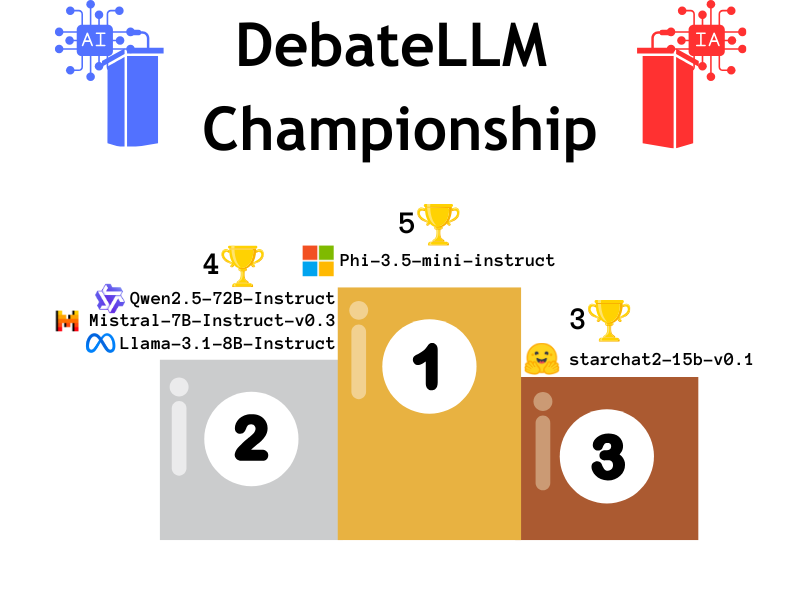